In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
articles_df = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/DataScopus/AnalisisGrafos/raw_data/articles.csv")
authors_df = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/DataScopus/AnalisisGrafos/raw_data/authors.csv")
author_article_links_df = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/DataScopus/AnalisisGrafos/raw_data/articles_authors.csv")
affiliations_df = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/DataScopus/AnalisisGrafos/raw_data/affiliations.csv")
author_institution_links_df = pd.read_csv("/content/drive/MyDrive/Universidad/Tesis/DataScopus/AnalisisGrafos/raw_data/authors_affiliations.csv")

In [3]:
author_links = author_article_links_df.merge(
    author_institution_links_df, on='author_id', how='left'
)

# 2. Merge with institution data
author_links = author_links.merge(
    affiliations_df, left_on='affiliation_id', right_on='identifier', how='left', suffixes=('', '_inst')
)

# 3. Merge with article data to bring in publication details
full_df = author_links.merge(
    articles_df, left_on='article_id', right_on='identifier', how='left', suffixes=('', '_article')
)

# 4. Extract year for grouping
full_df['pub_year'] = pd.to_datetime(full_df['publication_date']).dt.year

# 4. Extract year for grouping
full_df['pub_year'] = pd.to_datetime(full_df['publication_date'], errors='coerce').dt.year

# Filter
full_df = full_df[
    (full_df['pub_year'] >= 1990) &
    (full_df['pub_year'] <= 2019)
]

# 5. Group by institution and year
inst_yearly_counts = (
    full_df.groupby(['affiliation_name', 'pub_year'])
    .agg(num_publications=('article_id', 'nunique'))
    .reset_index()
)

In [4]:
affiliation = 'Escuela Politécnica Nacional'

In [5]:
ua_data = inst_yearly_counts[inst_yearly_counts['affiliation_name'] == affiliation]
ua_data = ua_data.sort_values('pub_year')

# split last year to test the model
train_data = ua_data.iloc[:-1]
test_data = ua_data.iloc[-1:]

# Train Linear Regression on train_data
X_train = train_data['pub_year'].values.reshape(-1, 1)
y_train = train_data['num_publications'].values

X_test = test_data['pub_year'].values.reshape(-1, 1)
y_test = test_data['num_publications'].values

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict for future years
future_years = np.array([2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030]).reshape(-1, 1)
future_preds = model.predict(future_years)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

# Optional: View predicted values
for year, pred in zip(future_years.flatten(), future_preds):
    print(f"Predicted publications in {year}: {pred:.2f}")

MAE:  437.54
MSE:  191442.89
RMSE: 437.54
Predicted publications in 2023: 278.17
Predicted publications in 2024: 288.85
Predicted publications in 2025: 299.53
Predicted publications in 2026: 310.21
Predicted publications in 2027: 320.89
Predicted publications in 2028: 331.57
Predicted publications in 2029: 342.25
Predicted publications in 2030: 352.93


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


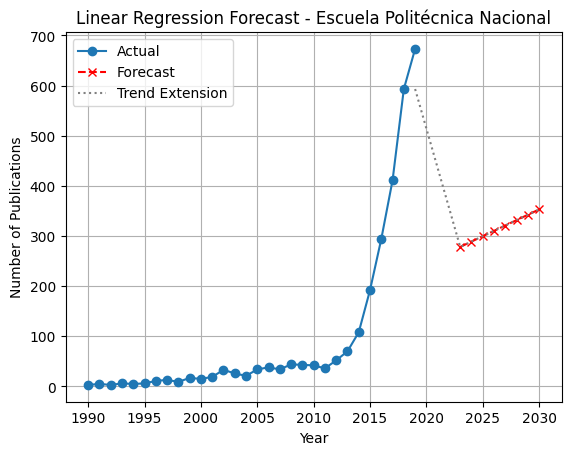

In [6]:
connector_x = np.concatenate([
    [ua_data['pub_year'].values[-1]],  # Last known year
    future_years.flatten()             # Future years
])
connector_y = np.concatenate([
    [y_train[-1]],                     # Last known value
    future_preds                       # Forecasted values
])

plt.plot(ua_data['pub_year'], ua_data['num_publications'].values, marker='o', label='Actual')

plt.plot(future_years.flatten(), future_preds, marker='x', linestyle='--', label='Forecast', color='red')

plt.plot(connector_x, connector_y, linestyle=':', color='gray', label='Trend Extension')

plt.title(f"Linear Regression Forecast - {affiliation}")
plt.xlabel("Year")
plt.ylabel("Number of Publications")
plt.grid(True)
plt.legend()
plt.show()